In [1]:
using DataStructures: DefaultDict
using CSV
using Clp
using Ipopt
using JuMP
using PyPlot
using DataFrames
using LinearAlgebra

In [2]:
raw = CSV.read("Metro_Transit_Ridership_by_Route_Weekday.csv", DataFrame) #main data
raw2 = CSV.read("Metro_Transit_Ridership_by_Stop.csv", DataFrame)         #not needed
raw3 = CSV.read("Metro_Transit_Ridership_by_Intersection.csv", DataFrame) #intersection info
delete!(raw3, [1]);

In [3]:
raw =first(raw , 400);

In [4]:
totalBoardings = combine(groupby(raw, :Route), :DailyBoardings => sum);
df = innerjoin(raw, totalBoardings, on = :Route)
rename!(df, :DailyBoardings_sum => :RouteBoardings);

In [5]:
m = DefaultDict(0)
for row1 in eachrow(df)
    for row2 in eachrow(df)
        if row1 != row2
            if row1[:Route] == row2[:Route]
                part = row2[:DailyBoardings]/(row1[:RouteBoardings]-row1[:DailyBoardings])
                m[(row1[:StopID],row2[:StopID])] += row1[:DailyBoardings]*part
            end
        end
    end
end

In [6]:
mvmt = DataFrame(From = Int64[], To = Int64[],Num = Float64[])
for ((a,b),c) in m
    push!(mvmt,(a,b,c))
end

In [7]:
pos1 = select(raw2,[:Lat,:Lon,:StopID])
rename!(pos1, :Lat => :FromLat,:Lon => :FromLon)
pos2 = select(raw2,[:Lat,:Lon,:StopID])
rename!(pos2, :Lat => :ToLat,:Lon => :ToLon)
mvmtPos = innerjoin(mvmt, pos1, on = :From=>:StopID)
mvmtPos = innerjoin(mvmtPos, pos2, on = :To=>:StopID);

In [8]:
function findClosest(lat,lon)
    best = (99,-1)
    for row in eachrow(raw3)
        dist = (row[:Lat]-lat)^2+(row[:Lon]-lon)^2
        best = min(best,(dist,row[:IntersectionID]))
    end
    return best      
end;

In [9]:
i = []
for row in eachrow(mvmtPos)
    push!(i, findClosest(row[:FromLat],row[:FromLon] )[2] )
end
mvmtPos[!,:FromInt] = i
i = []
for row in eachrow(mvmtPos)
    push!(i, findClosest(row[:ToLat],row[:ToLon] )[2] )
end
mvmtPos[!,:ToInt] = i;

In [10]:
mvmtInt = sort(combine(groupby(mvmtPos, [:FromInt,:ToInt]), :Num => sum),[1,2])
mvmtInt[!,:Flow] = convert.(Int64, round.(mvmtInt[!,:Num_sum],digits=1)*10 )
filteredFlow = filter(:Flow => x -> x >0, mvmtInt)
filteredFlow = filter([:FromInt,:ToInt] => (x,y) -> x !=y, filteredFlow);

In [11]:
interset = union(Set(filteredFlow[!,:FromInt]), Set(filteredFlow[!,:ToInt]))
inters = filter(:IntersectionID => x -> x in interset, raw3)
N = nrow(inters)
M = N^2-N
reIndex = Dict()
for (i,v) in enumerate(inters[!,:IntersectionID] )
    reIndex[v] = i
end
inters[!,:IntersectionID] = collect(1:N);
N

79

In [12]:
function cost(x1,y1,x2,y2)
    return  (x1-x2)^2 + (y1-y2)^2 
end;

In [13]:
A = Array{Int}(undef, N, 0)
c = Vector{Float64}(undef, 0)
for row1 in eachrow(inters)
    for row2 in eachrow(inters)
        if row1[:IntersectionID] != row2[:IntersectionID]
            e = zeros(Int8, N)
            e[row1[:IntersectionID]] = 1
            e[row2[:IntersectionID]] = -1
            A = [A e]
            push!(c,cost(row1[:Lat],row1[:Lon],row2[:Lat],row2[:Lon]))
        end
    end
end

In [14]:
m = Model(with_optimizer(Clp.Optimizer))
set_silent(m)
numFlows = nrow(filteredFlow)
@variable(m, X[1:numFlows, 1:M]>=0)
for (i, row) in enumerate(eachrow(filteredFlow))
    b = zeros(Int64, N)
    b[reIndex[row[:FromInt]]] = row[:Flow]
    b[reIndex[row[:ToInt]]] = -row[:Flow]
    @constraint(m, A*(X[i,:]) .== b)
end
@expression(m, x,  sum(X,dims=1) )
@objective(m,Min,dot(x,c));

In [15]:
optimize!(m)

In [16]:
solution_summary(m)

* Solver : Clp

* Status
  Termination status : OPTIMAL
  Primal status      : FEASIBLE_POINT
  Dual status        : FEASIBLE_POINT
  Message from the solver:
  "0 - optimal"

* Candidate solution
  Objective value      : 3.6142195536885278

* Work counters
  Solve time (sec)   : 202.17469


In [17]:
x_opt = value.(x);

In [18]:
sum(x_opt.!= 0)

240

In [19]:
numFlows

1848

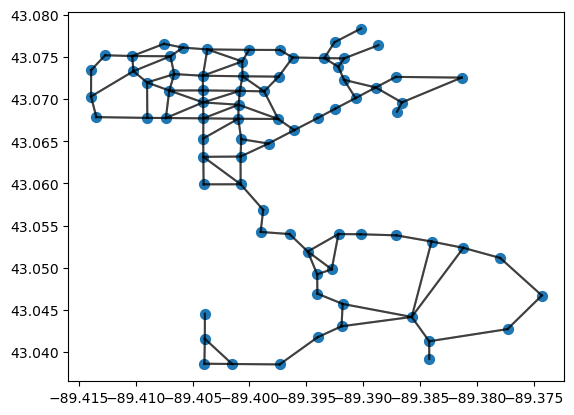

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/ankurgarg/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


In [20]:
X = round.(inters[!,:X],digits = 6)
Y = round.(inters[!,:Y],digits = 6)
scatter(X,Y,s=50);
i = 1
for row1 in eachrow(inters)
    for row2 in eachrow(inters)
        if row1[:IntersectionID] != row2[:IntersectionID]
            if(x_opt[i]>0)
                plot((row1[:Lon], row2[:Lon]),(row1[:Lat], row2[:Lat]),color = "black",alpha = .5)
                #println("$(row1[:IntersectionID]) $(row2[:IntersectionID]) $(x_opt[i])")
            end
            i+=1
        end
    end
end

In [21]:
nrow(CSV.read("Metro_Transit_Ridership_by_Route_Weekday.csv", DataFrame) )

3847